# Analisis del problema
El análisis del problema de predecir precios a futuro, en este caso de acciones, implica considerar una serie de variables y patrones históricos que influyen en el comportamiento del mercado. La base de datos proporcionada contiene información detallada sobre precios de apertura, cierre, máximos y mínimos, junto con el volumen de transacciones de diferentes acciones a lo largo del tiempo. Al estudiar estos datos, se pueden identificar tendencias y ciclos estacionales, así como eventos específicos que impactan los precios, como reportes de ganancias, cambios económicos y decisiones políticas. La complejidad del mercado requiere el uso de técnicas de modelado estadístico y aprendizaje automático para crear predicciones precisas. Estos modelos deben ser validados mediante la comparación con datos históricos para asegurar su fiabilidad, permitiendo a los inversores tomar decisiones informadas sobre sus estrategias de compra y venta.

# Entendimiento de los datos
`date`: (object) Fecha de la observación en formato YYYY-MM-DD.

`open`: (float64) Precio de apertura de la acción en ese día.

`high`: (float64) Precio más alto alcanzado por la acción en ese día.

`low`: (float64) Precio más bajo alcanzado por la acción en ese día.

`close`: (float64) Precio de cierre de la acción en ese día.

`volume`: (int64) Número total de acciones negociadas en ese día.

`Name`: (object) Nombre del símbolo de la acción (ticker) correspondiente.


# Exploración de los datos

## Librerias

In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
import itertools
import statsmodels.api as sm
warnings.filterwarnings("ignore")

In [6]:
# Load the dataset
df = pd.read_csv('../datasets/spStocks.csv')
df = df.drop(columns=['Name'])
df['date'] = pd.to_datetime(df['date'])
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    619040 non-null  datetime64[ns]
 1   open    619029 non-null  float64       
 2   high    619032 non-null  float64       
 3   low     619032 non-null  float64       
 4   close   619040 non-null  float64       
 5   volume  619040 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 28.3 MB
None


In [7]:
df = df.groupby('date').mean().reset_index()

for col in df.columns:
    if df[col].dtype == 'float64':
        df[col] = df[col].fillna(df[col].median())


df = df.sort_values(by='date')
df = df.set_index('date')

full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')

df = df.reindex(full_range)

df = df.interpolate(method='linear')

print(df.isnull().sum())
print(df.head(5))
print(df.tail(5))

y = df['close']


open      0
high      0
low       0
close     0
volume    0
dtype: int64
                 open       high        low      close        volume
2013-02-08  58.068730  58.659286  57.802352  58.368654  4.643484e+06
2013-02-09  58.164339  58.668215  57.831592  58.336501  4.459803e+06
2013-02-10  58.259948  58.677144  57.860832  58.304348  4.276123e+06
2013-02-11  58.355556  58.686073  57.890072  58.272196  4.092442e+06
2013-02-12  58.321741  58.771200  57.954938  58.404071  5.122822e+06
                  open        high         low       close        volume
2018-02-03  111.448825  112.596524  108.718863  109.342756  6.007675e+06
2018-02-04  110.671135  112.054822  107.283240  107.977531  6.566647e+06
2018-02-05  109.893446  111.513119  105.847616  106.612307  7.125618e+06
2018-02-06  104.739475  108.884319  103.545130  108.169149  8.063527e+06
2018-02-07  107.873911  110.007161  106.818901  107.762208  5.674533e+06


In [8]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


# Modelo Machine Learning

In [9]:
# Find best parameters
bestAIC = np.inf
bestParms = None
bestSeasonalParms = None
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(y, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            results = mod.fit(disp=False)
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            if results.aic < bestAIC:
                bestAIC = results.aic
                bestParms = param
                bestSeasonalParms = param_seasonal
        except:
            continue

print('Best ARIMA{}x{}12 - AIC:{}'.format(bestParms, bestSeasonalParms, bestAIC))

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:21343.801680657405
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:18789.548004578617
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:7077.826093054747
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:7027.367571118835
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:7010.286293760241
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:6966.403591316357
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:7029.503181558246
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:7025.5352566419215
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:18829.912856929455
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:16300.922409355007
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:5428.874329769558
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:5336.564168193642
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:5384.232241089107
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:5401.43806599406
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:5343.746399741315
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:5339.35324188745
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2530.4686950088844
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:2523.734008089107
ARIMA(

In [10]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(0, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit(disp=False)
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4014      0.236      1.701      0.089      -0.061       0.864
ma.L1         -0.3443      0.241     -1.429      0.153      -0.817       0.128
ma.S.L12      -0.0026      0.020     -0.126      0.900      -0.042       0.037
sigma2         0.2342      0.004     54.309      0.000       0.226       0.243


# Evaluaciones

DatetimeIndex(['2018-02-08', '2018-02-09', '2018-02-10', '2018-02-11',
               '2018-02-12', '2018-02-13', '2018-02-14', '2018-02-15',
               '2018-02-16', '2018-02-17',
               ...
               '2020-07-23', '2020-07-24', '2020-07-25', '2020-07-26',
               '2020-07-27', '2020-07-28', '2020-07-29', '2020-07-30',
               '2020-07-31', '2020-08-01'],
              dtype='datetime64[ns]', length=906, freq='D')
Predicción para 2020-08-01 00:00:00: 107.77026593393572


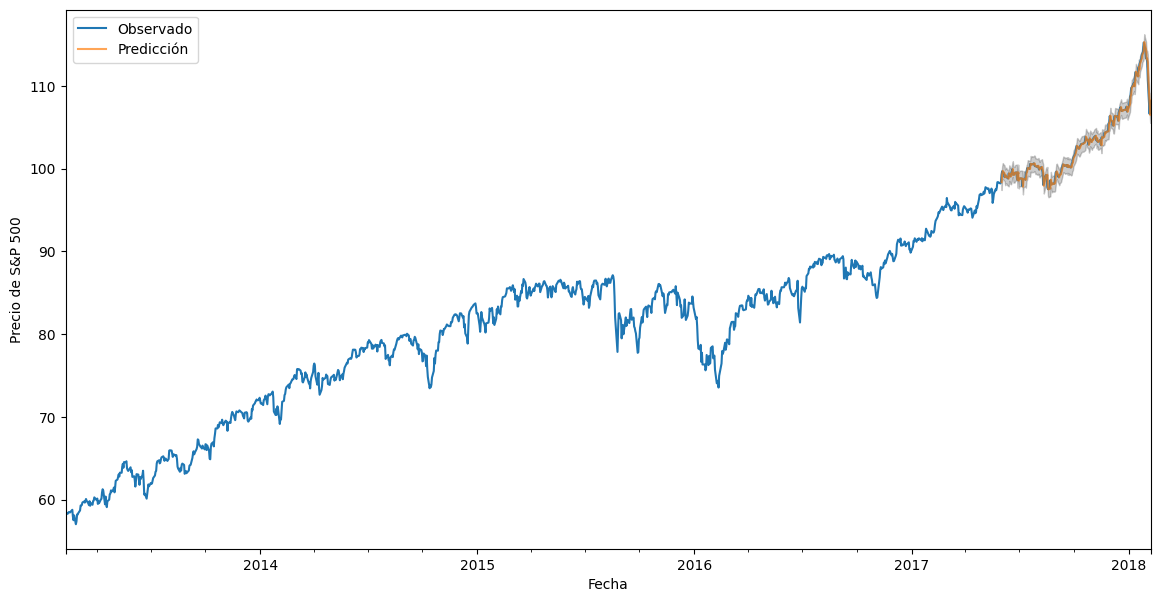

In [11]:
my_date = pd.to_datetime('2020-08-01')  #

if my_date > y.index[-1]:
    steps_a_predecir = (my_date - y.index[-1]).days
    forecast = results.get_forecast(steps=steps_a_predecir)
    print(forecast.predicted_mean.index)

    prediccion = forecast.predicted_mean.iloc[-1]
    print(f'Predicción para {my_date}: {prediccion}')
else:
    print(f'La fecha {my_date} está dentro de los datos históricos.')

pred = results.get_prediction(start=pd.to_datetime('2017-06-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2013':].plot(label='Observado')
pred.predicted_mean.plot(ax=ax, label='Predicción', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Fecha')
ax.set_ylabel('Precio de S&P 500')
plt.legend()
plt.show()

# Resultados
El resumen de los resultados muestra los coeficientes estimados de un modelo de series temporales, probablemente un modelo ARIMA o SARIMA. Aquí están los puntos clave:

- **Coeficientes**:
  - **`ar.L1`**: El coeficiente de la parte autorregresiva (AR) de orden 1 es 0.4014, con un valor p de 0.089. Esto sugiere una relación positiva entre el valor actual y el valor del periodo anterior, aunque no es estadísticamente significativo al nivel del 5%.
  - **`ma.L1`**: El coeficiente de la media móvil (MA) de orden 1 es -0.3443, con un valor p de 0.153, indicando que la relación no es significativa. Un valor negativo podría sugerir una tendencia a corregir errores de pronóstico hacia abajo.
  - **`ma.S.L12`**: Este término representa la media móvil estacional, cuyo coeficiente es -0.0026 y también no es significativo (p=0.900), lo que indica que no contribuye significativamente al modelo en términos estacionales.
  
- **Varianza (`sigma2`)**: El término sigma2 tiene un coeficiente de 0.2342 y es altamente significativo (p=0.000), lo que sugiere que la varianza de los errores del modelo es pequeña y está bien estimada.

En resumen, aunque algunos coeficientes presentan tendencias interesantes, como el coeficiente AR, ninguno alcanza un nivel de significancia estadística fuerte, a excepción de la varianza de los errores. Esto sugiere que, aunque el modelo puede capturar ciertas dinámicas de la serie temporal, se requerirían ajustes adicionales o la inclusión de variables adicionales para mejorar la robustez y la significancia del modelo.